In [99]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [28]:
df = pd.read_csv("books.csv")

In [29]:
df.head()

,Book Id,Title,Author,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genres
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,"Fantasy;Young Adult;Fiction;Fantasy,Magic;Chil..."
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,"Fantasy;Young Adult;Fiction;Fantasy,Magic;Chil..."
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,"Fantasy;Fiction;Young Adult;Fantasy,Magic;Chil..."
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,"Fantasy;Fiction;Young Adult;Fantasy,Magic;Chil..."
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,"Fantasy;Young Adult;Fiction;Fantasy,Magic;Adve..."


In [30]:
df.shape

(11127, 13)

# Data Cleaning

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Book Id             11127 non-null  int64  
 1   Title               11127 non-null  object 
 2   Author              11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
 12  genres              11030 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 1.1+ MB


In [32]:
df.isnull().sum()

Book Id                0
Title                  0
Author                 0
average_rating         0
isbn                   0
isbn13                 0
language_code          0
num_pages              0
ratings_count          0
text_reviews_count     0
publication_date       0
publisher              0
genres                97
dtype: int64

In [33]:
df.describe()

,Book Id,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,21310.938887,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498
std,13093.358023,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10287.000000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780586e+12,299.000000,7.450000e+02,46.000000
75%,32104.500000,4.135000,9.780873e+12,416.000000,4.993500e+03,237.500000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [34]:
df['genres'] = df.groupby('Author')['genres'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else "Romance")

In [50]:
df['genres'] = df['genres'].replace('Unknown', 'Romance')

In [51]:
df.isnull().sum()

Book Id               0
Title                 0
Author                0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
genres                0
dtype: int64

# Data Visualization

In [52]:
sns.set()

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


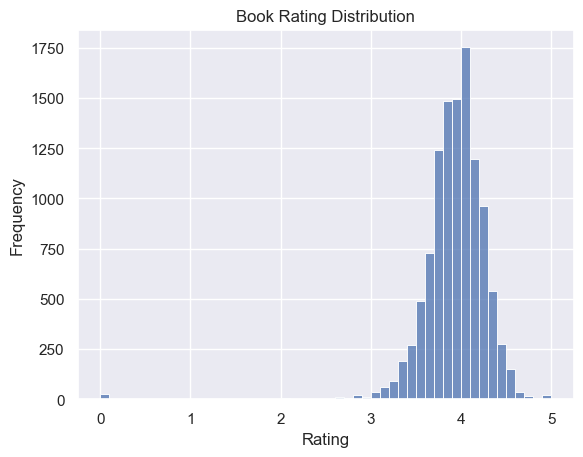

In [53]:
# User-ratings
sns.histplot(df['average_rating'], bins = 50)
plt.title("Book Rating Distribution")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

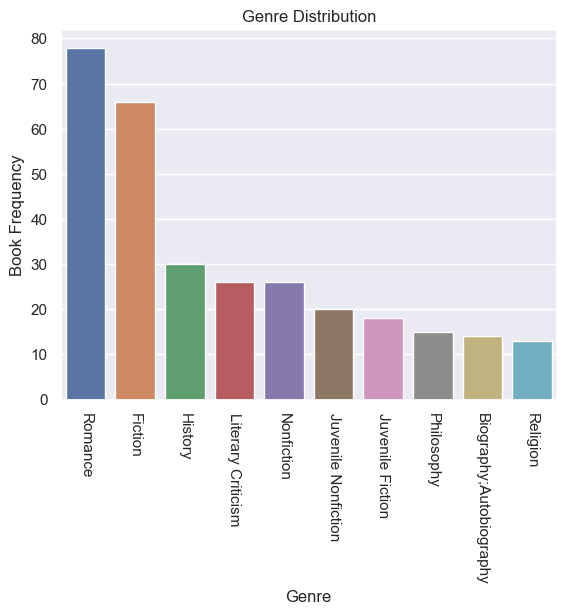

In [66]:
# Genre Distribution
genre_count = df['genres'].value_counts()
top_genre = genre_count.nlargest(10)
sns.barplot(x = top_genre.index, y = top_genre.values)
plt.title("Genre Distribution")
plt.xlabel('Genre')
plt.ylabel('Book Frequency')
plt.xticks(rotation=270)
plt.show()

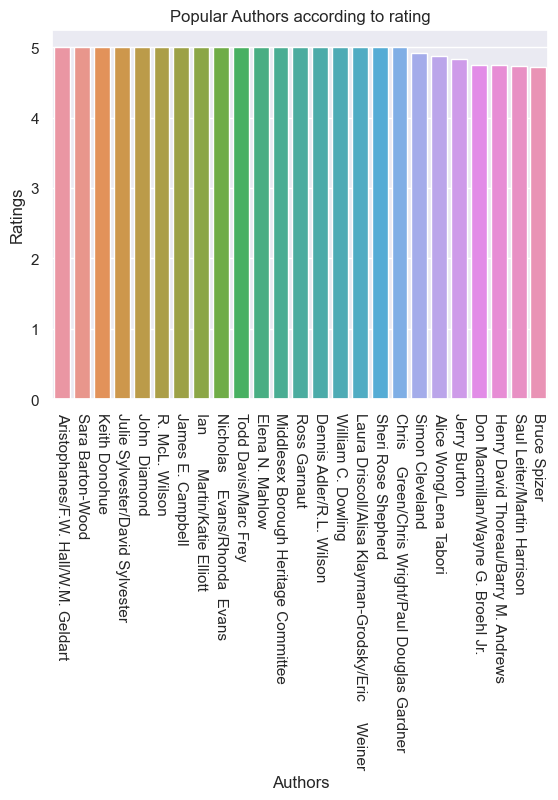

In [73]:
top_authors = df.groupby('Author')['average_rating'].mean().sort_values(ascending = False).head(25)
sns.barplot(x = top_authors.index, y = top_authors.values)
plt.title("Popular Authors according to rating")
plt.xlabel("Authors")
plt.ylabel("Ratings")
plt.xticks(rotation = 270)
plt.show()

# Model

In [75]:
df['details'] = df['Title'] + df['genres'] + df['Author'] + df['publisher']

In [77]:
# Vectorization
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(df['details'])

In [80]:
cosineSimilarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [84]:
cosineSimilarity

array([[1.        , 0.82883302, 0.66894706, ..., 0.05060996, 0.        ,
        0.07675095],
       [0.82883302, 1.        , 0.67819526, ..., 0.05130965, 0.        ,
        0.07781204],
       [0.66894706, 0.67819526, 1.        , ..., 0.05417936, 0.        ,
        0.08216401],
       ...,
       [0.05060996, 0.05130965, 0.05417936, ..., 1.        , 0.09285188,
        0.12550681],
       [0.        , 0.        , 0.        , ..., 0.09285188, 1.        ,
        0.0124012 ],
       [0.07675095, 0.07781204, 0.08216401, ..., 0.12550681, 0.0124012 ,
        1.        ]])

In [107]:
def recommendations(title, cosineSimilarity = cosineSimilarity):
    keywords = re.findall(r'\w+', title.lower())
    pattern = '|'.join(keywords)
    matching_titles = df[df['Title'].str.contains(pattern, case=False, na=False)]
    if matching_titles.empty:
        return "No books found matching that title."
    id = matching_titles.index[0]
    similarityScores = sorted(list(enumerate(cosineSimilarity[id])), key = lambda x: x[1], reverse = True)
    similarityScores = similarityScores[1: 20]
    indices = [score[0] for score in similarityScores]
    return df['Title'].iloc[indices]

In [111]:
recommendations('Giving Good Weight')

8219                Curry: A Tale of Cooks and Conquerors
2391                               Comfort Me With Apples
2390    Comfort Me with Apples: More Adventures at the...
9848    How to Be a Domestic Goddess: Baking and the A...
9847    How to Be a Domestic Goddess: Baking and the A...
9846                        Feast: Food to Celebrate Life
9849                                       Forever Summer
1167                       The Barefoot Contessa Cookbook
9909    The Bread Baker's Apprentice: Mastering the Ar...
9961                                   Bone In The Throat
2455                                        Jamie's Italy
2456       Jamie's Dinners: The Essential Family Cookbook
348                                Giada's Family Dinners
1904                The McDougall Quick and Easy Cookbook
5422                Essentials of Classic Italian Cooking
2801               Not Your Mother's Slow Cooker Cookbook
6810    The Best Recipes in the World: More Than 1 000...
349     Everyd